# Sound identification
WARNING!!!!!
2 Cells in the code below will below give error. Ignore the errors as the code still functions.

In this mini project you will try and identify various types of sounds. This project can be considered as part image classifciation and part sequence modelling.

![Some of the images in spectrogram format](esc50.gif)



There are 2000 different sounds available covering 50 different categories. The different targets (labels), named categories and the number of sounds in each category are listed below.

|Target | Category | Count |
|---------|---------|-------|
| 0 | airplane | 40 |
| 1 | breathing | 40 |
| 2 | brushing_teeth | 40 |
| 3 | can_opening | 40 |
| 4 | car_horn | 40 |
| 5 | cat | 40 |
| 6 | chainsaw | 40 |
| 7 | chirping_birds | 40 |
| 8 | church_bells | 40 |
| 9 | clapping | 40 |
| 10 | clock_alarm | 40 |
| 11 | clock_tick | 40 |
| 12 | coughing | 40 |
| 13 | cow | 40 |
| 14 | crackling_fire | 40 |
| 15 | crickets | 40 |
| 16 | crow | 40 |
| 17 | crying_baby | 40 |
| 18 | dog | 40 |
| 19 | door_wood_creaks | 40 |
| 20 | door_wood_knock | 40 |
| 21 | drinking_sipping | 40 |
| 22 | engine | 40 |
| 23 | fireworks | 40 |
| 24 | footsteps | 40 |
| 25 | frog | 40 |
| 26 | glass_breaking | 40 |
| 27 | hand_saw | 40 |
| 28 | helicopter | 40 |
| 29 | hen | 40 |
| 30 | insects | 40 |
| 31 | keyboard_typing | 40 |
| 32 | laughing | 40 |
| 33 | mouse_click | 40 |
| 34 | pig | 40 |
| 35 | pouring_water | 40 |
| 36 | rain | 40 |
| 37 | rooster | 40 |
| 38 | sea_waves | 40 |
| 39 | sheep | 40 |
| 40 | siren | 40 |
| 41 | sneezing | 40 |
| 42 | snoring | 40 |
| 43 | thunderstorm | 40 |
| 44 | toilet_flush | 40 |
| 45 | train | 40 |
| 46 | vacuum_cleaner | 40 |
| 47 | washing_machine | 40 |
| 48 | water_drops | 40 |
| 49 | wind | 40 |


## Data description
The data comes in the form of short WAV files, in the code below we show how you can convert the WAV file into a spectrogram which is a plot of frequency vs time. For more details you can see the [dataset decription](https://doi.org/10.1145/2733373.2806390).

## Machine learning tasks
1. Develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the spectrogram images.
2. Develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the waveforms.
3. Determine which of the categories are easiest and hardest to separate.

## Potential extension tasks
1. Use an appropriate technique to determine how to group the 50 categories into a smaller number of super-categories
2. Develop a machine learning algorithm that can classify the sounds in terms of the super categories
3. Record some sounds of your own (or find suitable sounds otherwise) and test how well your model can categorise the new sounds.
4. Develop a generative network that can create fake sounds from one or more of the categories.


## Things to remember
Investigate the shape of the data. For example are all of the recordings the same length? think about what techniques might be well suited to clustering the sounds into the super-categories (if you choose to do the optional task).

In [1]:
import librosa 
#Librosa is a helper library for reading audo files you might need to pip install librosa (or conda install librosa)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def getMeta():
    return pd.read_csv('meta/sounds.csv')

def getSignal(fileName):
    return librosa.load(fileName, sr=44100)[0]

def getSpect(signal):
    spec = librosa.feature.melspectrogram(y=signal, sr=44100, n_fft=2205, hop_length=441)
    spec = librosa.power_to_db(spec)
    return spec

def getSignalSpect(meta,number):
    recording=meta['filename'][number]
    signal = getSignal('audio/'+recording)
    return signal,getSpect(signal)
    

meta=getMeta()

In [2]:
print("There are a total of",meta['category'].size,"sounds")
categories = meta[['category']].value_counts() #Count the instances of each value
print("Coming from",categories.size,"categories")
print("So each category has",meta['category'].size//categories.size,"sounds")
print("In the meta data we have",meta.columns)
#print(meta.iloc[5])
    


There are a total of 2000 sounds
Coming from 50 categories
So each category has 40 sounds
In the meta data we have Index(['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take'], dtype='object')


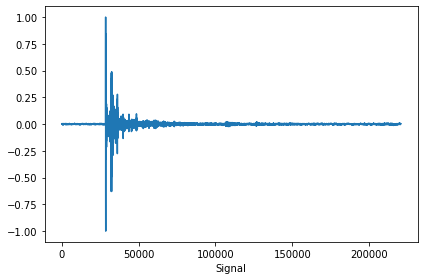

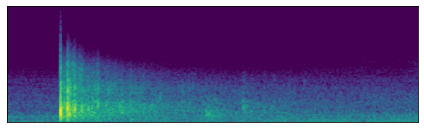

In [3]:
signal,spect=getSignalSpect(meta,20)
fig , ax =plt.subplots()
ax.plot(np.arange(signal.shape[0]),signal)
ax.set_xlabel("Sample Number")
ax.set_xlabel("Signal")
fig.tight_layout()

fig,ax =plt.subplots() 
ax.imshow(spect, origin='lower', interpolation=None, cmap='viridis', aspect=1.1)
#ax.set_title(f'{category} - {recording}', fontsize=11)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
fig.tight_layout()


In [4]:
signal_d = []
spect_d = []
for i in range(0,2000): ####Obtain data and put into an array
    signal,spect=getSignalSpect(meta,i)
    signal_d.append(signal)
    spect_d.append(spect)
signal_d = np.array(signal_d)
spect_d = np.array(spect_d)

In [5]:
labels = np.array(meta['category']) 
meta_target = np.array(meta['target'])
# To convert the labels to categorical 50 classes
label_cat = tf.keras.utils.to_categorical(meta_target, 50) 
images = spect_d
labels = label_cat

# Spectrogram

### Strategy
The idea in then code below is to first deal with the spectrogram data. To do this a model with CNNs will be suitable as it will be dealing with images. Considering that CNNs will be used and the dataset is not really small ;converting the arrays into tf.datasets using tf.dataset methods to optimize the preprocessing, would be a good idea to save time running the code.

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels)) #### Make a dataset and have batches of data to optimize
dataset = dataset.shuffle(buffer_size = 100)
dataset = dataset.batch(32) 

In [7]:
### Do  a train validate test split
def train_validate_test(data, train_size , val_size, test_size): ### train etc size needs to be in percentages /floats
    """Function that takes a dataset, shuffles it then and splits it into train,val,test datasets"""
    data = data.shuffle(buffer_size = 100)
    full_size = len(data)
    train_ds = data.take(int(train_size * full_size)) ### Takes all data until train_size is full
    val_and_test = data.skip(int(train_size * full_size)) #data that skips the training data
    val_ds = val_and_test.take(int(val_size * full_size)) 
    test_ds = val_and_test.skip(int(val_size * full_size))
    return train_ds , val_ds , test_ds

train_dataset , validate_dataset , test_dataset = train_validate_test(dataset ,0.6 , 0.1 , 0.3)

In [8]:
train_dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)###improve perfomance of code timing 
validate_dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)### Prefetch process the next batch of data while training current data
test_dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)######cache prevents repeating tasks,autotune makes the amount data being prefetched be done automatically the amount can change each time

train_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))#### Convert to int8 as that stores the least amount data44
validate_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))
test_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))

<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 500), dtype=tf.float32, name=None), TensorSpec(shape=(None, 50), dtype=tf.int8, name=None))>

In [9]:
input_model_shape = (128,500) 
model = models.Sequential([
    layers.Conv1D(64 , kernel_size = 7, activation = 'relu', input_shape = input_model_shape),
    layers.MaxPooling1D(pool_size = 3,strides = 2),
    layers.BatchNormalization(),###normalize 
    layers.Conv1D(64 , kernel_size = 7, activation = 'relu', input_shape = input_model_shape),
    layers.MaxPooling1D(pool_size = 3,strides = 2),
    layers.Conv1D(32, kernel_size = 3, strides = 2, activation = 'tanh', input_shape = input_model_shape),
    layers.MaxPooling1D(pool_size = 3,strides = 2),
    layers.BatchNormalization(),


    
    layers.Flatten(),
    layers.Dense(120, activation = 'tanh'),
    layers.Dropout(0.01),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(50, activation = 'softmax'), ### To give predictions as probabilities
])

####using tanh for activation function as some images contain a lot of dark spots meaning a large amount of negative numbers

In [10]:
Optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(
    optimizer = Optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

estop = EarlyStopping (monitor = 'loss', min_delta = 0.000003, patience = 10, verbose = 1)####Made the stop condition impossible

I put early stopping  to make training more efficient when trying out previous model structures. However there is no need for it now the model structure is fine, so I just changed the stopping condition into being very unlikely ;instead of chaning the code.

In [11]:
history = model.fit(
    train_dataset,
    epochs = 50,
    batch_size = 32,
    verbose = 1,
    validation_data = validate_dataset,
    callbacks = [estop]
)

Epoch 1/50
37/37 [==============================] - 4s 59ms/step - loss: 3.8243 - accuracy: 0.0479 - val_loss: 3.9403 - val_accuracy: 0.0260
Epoch 2/50
37/37 [==============================] - 2s 47ms/step - loss: 3.4283 - accuracy: 0.1122 - val_loss: 3.4732 - val_accuracy: 0.1406
Epoch 3/50
37/37 [==============================] - 2s 46ms/step - loss: 3.2590 - accuracy: 0.1421 - val_loss: 3.4789 - val_accuracy: 0.1302
Epoch 4/50
37/37 [==============================] - 2s 44ms/step - loss: 3.0485 - accuracy: 0.1841 - val_loss: 3.0386 - val_accuracy: 0.1719
Epoch 5/50
37/37 [==============================] - 2s 48ms/step - loss: 2.9107 - accuracy: 0.2171 - val_loss: 2.8572 - val_accuracy: 0.2708
Epoch 6/50
37/37 [==============================] - 2s 45ms/step - loss: 2.6974 - accuracy: 0.2660 - val_loss: 2.8045 - val_accuracy: 0.2500
Epoch 7/50
37/37 [==============================] - 2s 45ms/step - loss: 2.5534 - accuracy: 0.3151 - val_loss: 3.1873 - val_accuracy: 0.1615
Epoch 8/50
37

In [12]:
model.evaluate(test_dataset)

20/20 [==============================] - 1s 11ms/step - loss: 0.9987 - accuracy: 0.7312


[0.9987221956253052, 0.731249988079071]

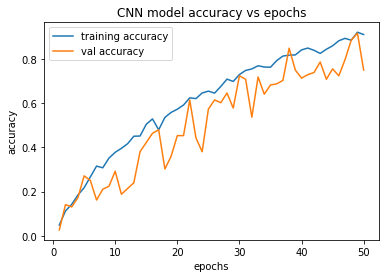

In [13]:
epochs = range(1,51) ###1 because epochs starts at 1 not 0 so must end at 50+1
plt.plot(epochs, history.history['accuracy'], label = 'training accuracy')
plt.plot(epochs, history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('CNN model accuracy vs epochs')
plt.legend(loc = 'best')

## Warning 
The cell below has a runtime of around 2-5mins

In [14]:
y_pred_array = np.array([])
y_true_array = np.array([])
for i in range(0,100): ### Do multiple times due the model and dataset changing each time
    y_pred = np.array([])  
    y_true = np.array([])  
    for image_batch, label_batch in test_dataset: 
        y_true = np.append(y_true,(np.argmax(label_batch,axis = -1).flatten())) ### Label
        preds = model.predict(image_batch) ### Prediction
        y_pred = np.append(y_pred,(np.argmax(preds, axis = - 1).flatten()))
    y_pred_array = np.append(y_pred_array,y_pred)
    y_true_array = np.append(y_true_array,y_true)
## Flatten due the predictions being in batches and having looped multiple times
y_pred_array = y_pred_array.tolist()
y_true_array = y_true_array.tolist()


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 26ms/step


Text(339.0, 0.5, 'Actual value')

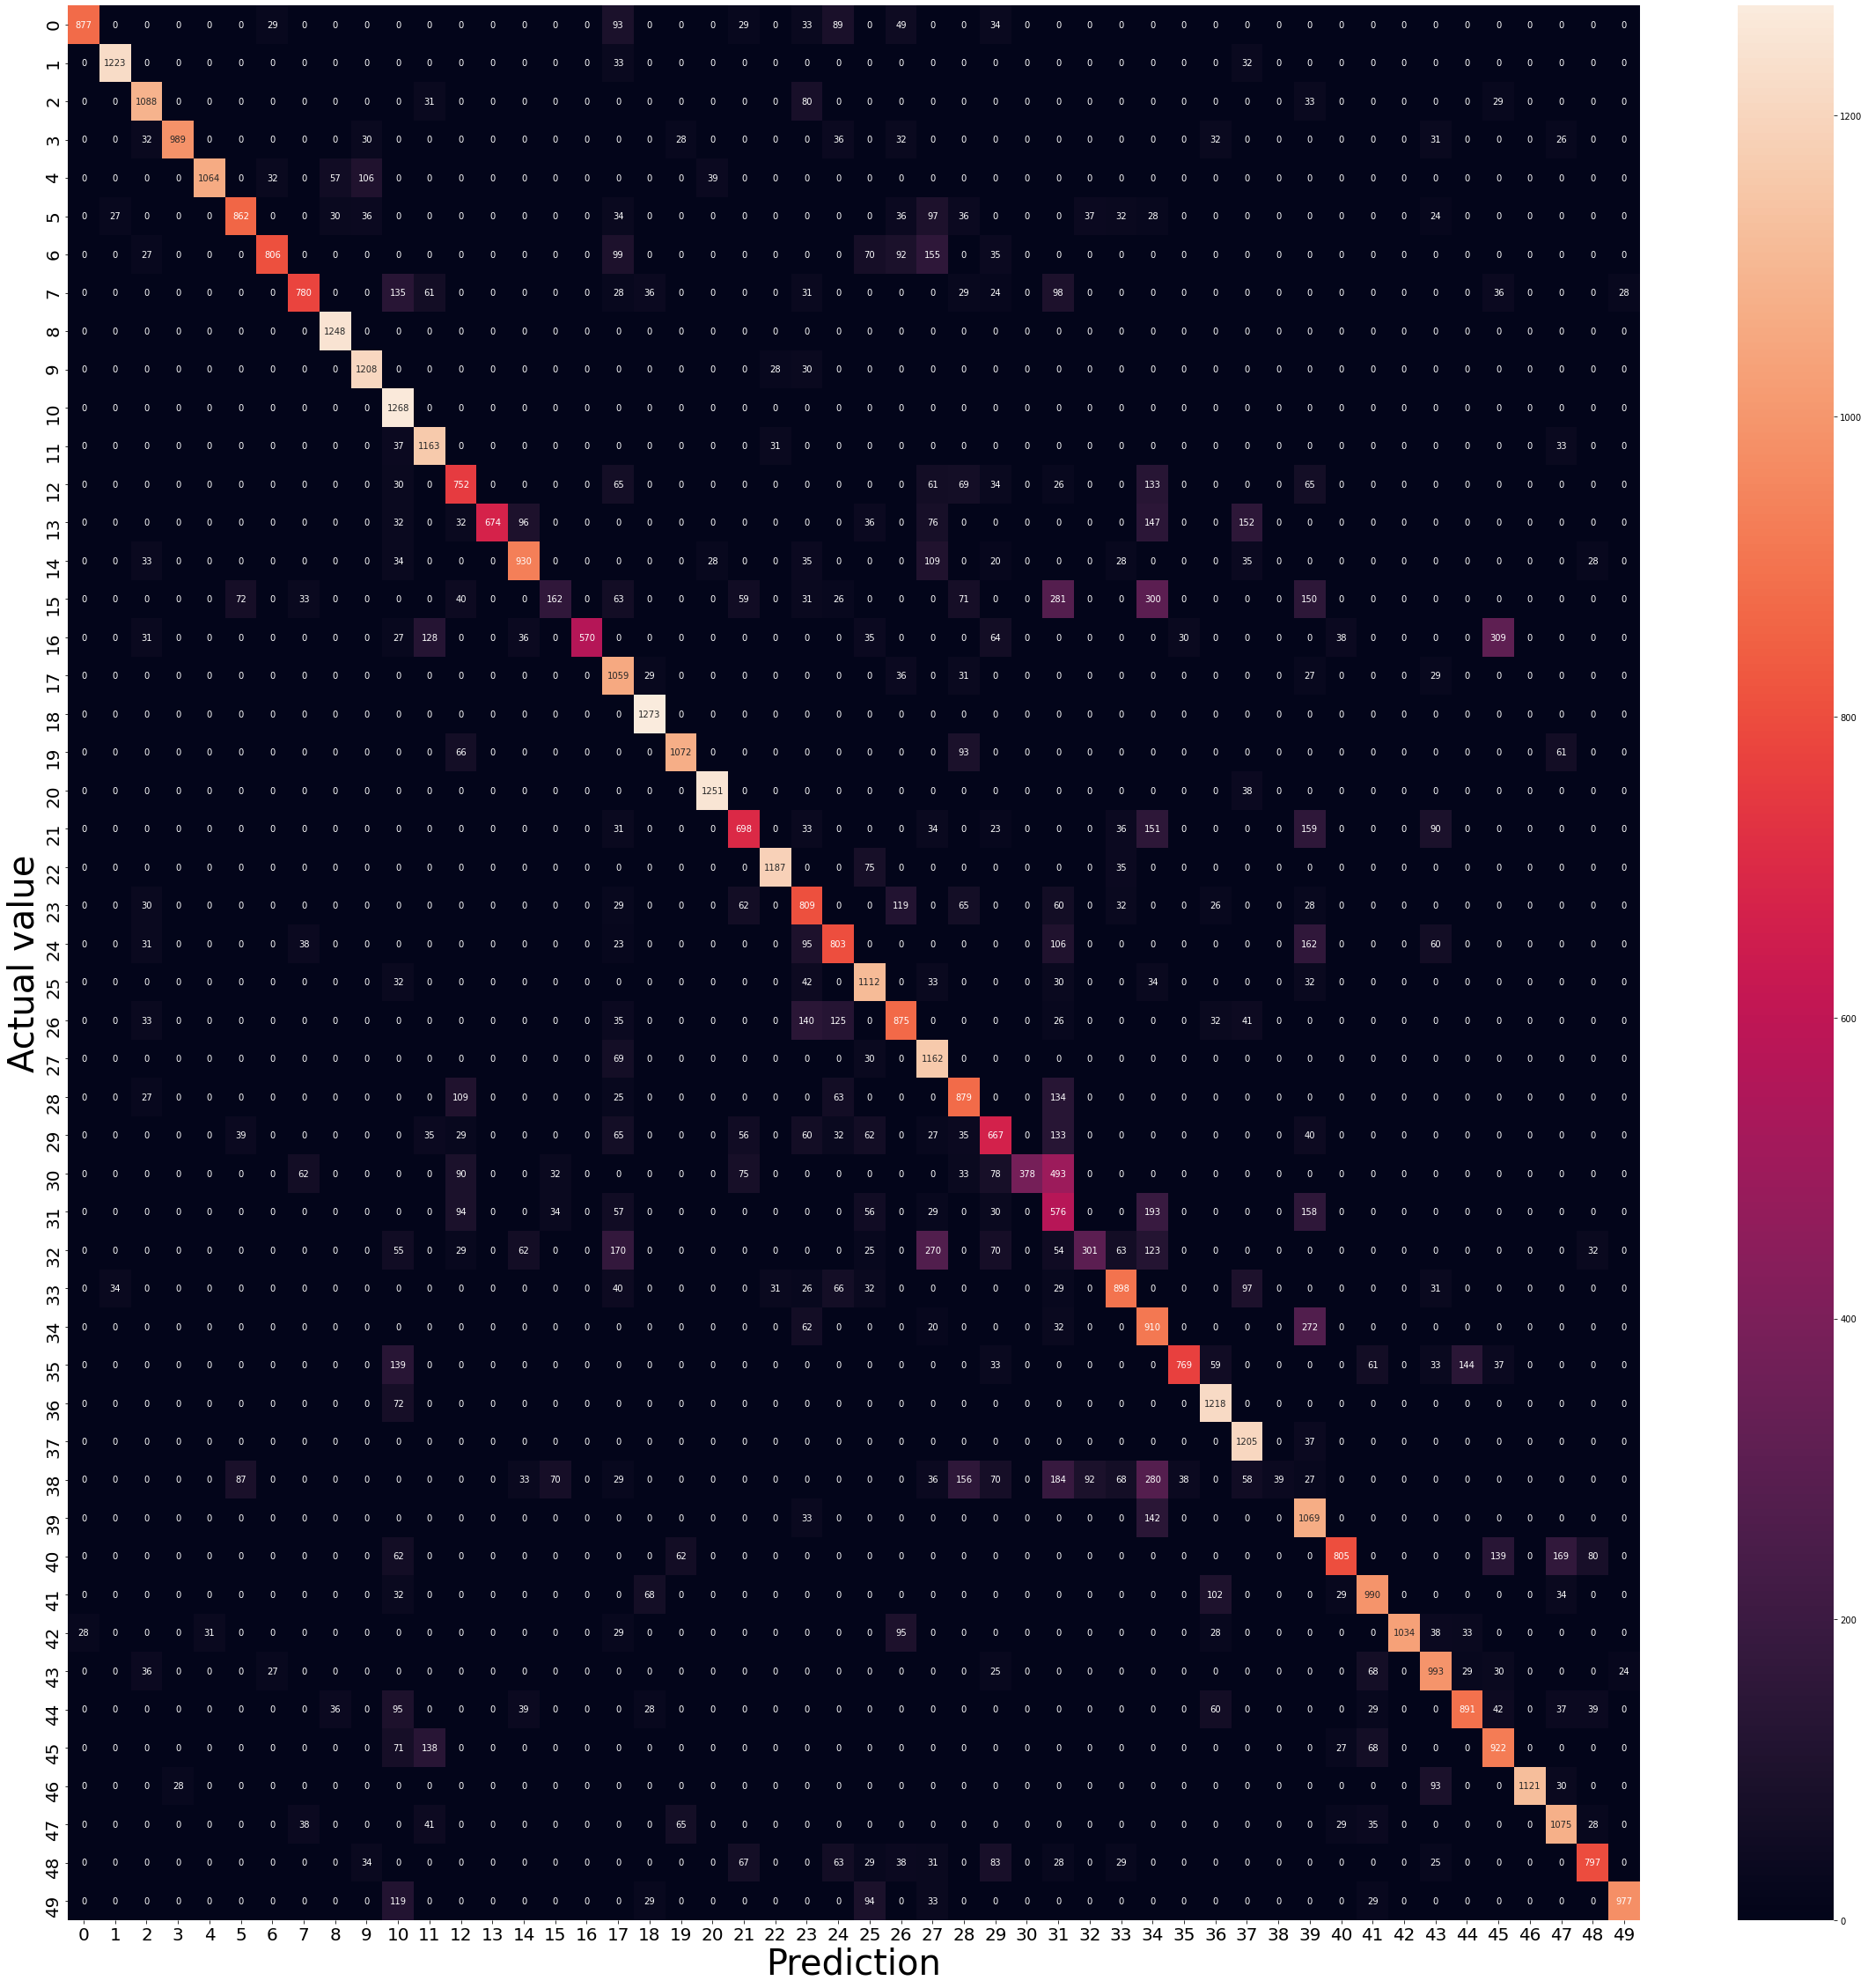

In [15]:
from sklearn.metrics import classification_report

cm = tf.math.confusion_matrix(labels = y_true_array, predictions = y_pred_array)
import seaborn as sn
plt.figure(figsize = (40,40))
sn.heatmap(cm, annot = True, fmt ='d')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Prediction',fontsize =40)
plt.ylabel('Actual value',fontsize = 40)

In [16]:
print("Classifiction Report \n" , classification_report(y_true_array , y_pred_array))

Classifiction Report 
               precision    recall  f1-score   support

         0.0       0.97      0.71      0.82      1233
         1.0       0.95      0.95      0.95      1288
         2.0       0.80      0.86      0.83      1261
         3.0       0.97      0.80      0.88      1236
         4.0       0.97      0.82      0.89      1298
         5.0       0.81      0.67      0.74      1279
         6.0       0.90      0.63      0.74      1284
         7.0       0.82      0.61      0.70      1286
         8.0       0.91      1.00      0.95      1248
         9.0       0.85      0.95      0.90      1266
        10.0       0.57      1.00      0.72      1268
        11.0       0.73      0.92      0.81      1264
        12.0       0.61      0.61      0.61      1235
        13.0       1.00      0.54      0.70      1245
        14.0       0.78      0.73      0.75      1280
        15.0       0.54      0.13      0.20      1288
        16.0       1.00      0.45      0.62      1268
    

Plot the categories the model is mistaking and see if they are visually similar.

In [17]:
sea_wave_df = meta.loc[meta['category'] == 'sea_waves']
crickets_df = meta.loc[meta['category'] == 'crickets']
keyboard_df = meta.loc[meta['category'] == 'keyboard_typing']
print(sea_wave_df.head())
print(crickets_df.head()) #####Want to show the spects for the 2 different cases and see if they are visually similar
print(keyboard_df.head())

             filename  fold  target   category  esc10  src_file take
148  1-28135-A-11.wav     1      11  sea_waves   True     28135    A
149  1-28135-B-11.wav     1      11  sea_waves   True     28135    B
195  1-39901-A-11.wav     1      11  sea_waves   True     39901    A
196  1-39901-B-11.wav     1      11  sea_waves   True     39901    B
207  1-43760-A-11.wav     1      11  sea_waves   True     43760    A
             filename  fold  target  category  esc10  src_file take
286  1-57316-A-13.wav     1      13  crickets  False     57316    A
287  1-57318-A-13.wav     1      13  crickets  False     57318    A
294  1-59102-A-13.wav     1      13  crickets  False     59102    A
317  1-65483-A-13.wav     1      13  crickets  False     65483    A
340   1-7456-A-13.wav     1      13  crickets  False      7456    A
             filename  fold  target         category  esc10  src_file take
36     1-137-A-32.wav     1      32  keyboard_typing  False       137    A
265  1-53501-A-32.wav     1 

Text(0.5, 1.0, 'Keyboard Spectrogram')

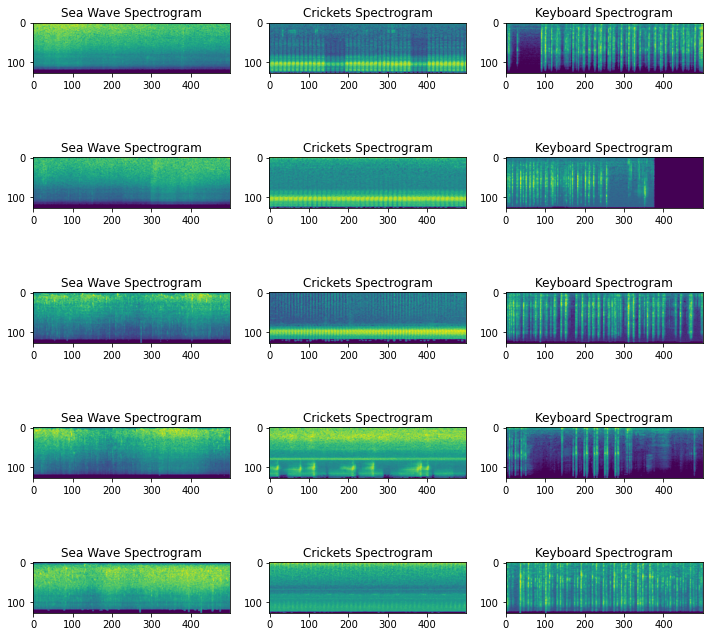

In [18]:
fig = plt.figure(figsize=(12,12))
rows = 5
columns = 3

fig.add_subplot(rows, columns, 1)   
plt.imshow(spect_d[148])  
plt.title("Sea Wave Spectrogram")
fig.add_subplot(rows, columns, 2) 
plt.imshow(spect_d[286])  
plt.title("Crickets Spectrogram")
fig.add_subplot(rows, columns, 3)   
plt.imshow(spect_d[36])  
plt.title("Keyboard Spectrogram")
fig.add_subplot(rows, columns, 4)   
plt.imshow(spect_d[149])  
plt.title("Sea Wave Spectrogram")
fig.add_subplot(rows, columns, 5) 
plt.imshow(spect_d[287])  
plt.title("Crickets Spectrogram")
fig.add_subplot(rows, columns, 6)   
plt.imshow(spect_d[265])  
plt.title("Keyboard Spectrogram")
fig.add_subplot(rows, columns, 7)  
plt.imshow(spect_d[195])  
plt.title("Sea Wave Spectrogram")
fig.add_subplot(rows, columns, 8) 
plt.imshow(spect_d[294])  
plt.title("Crickets Spectrogram")
fig.add_subplot(rows, columns, 9)   
plt.imshow(spect_d[302])  
plt.title("Keyboard Spectrogram")
fig.add_subplot(rows, columns, 10)   
plt.imshow(spect_d[196])  
plt.title("Sea Wave Spectrogram")
fig.add_subplot(rows, columns, 11) 
plt.imshow(spect_d[317])  
plt.title("Crickets Spectrogram")
fig.add_subplot(rows, columns, 12)   
plt.imshow(spect_d[309])  
plt.title("Keyboard Spectrogram")
fig.add_subplot(rows, columns, 13)   
plt.imshow(spect_d[207])  
plt.title("Sea Wave Spectrogram")
fig.add_subplot(rows, columns, 14) 
plt.imshow(spect_d[340])  
plt.title("Crickets Spectrogram")
fig.add_subplot(rows, columns, 15)   
plt.imshow(spect_d[355])  
plt.title("Keyboard Spectrogram")

### Analysis
From confusion matrix we the model is mixing up sea waves and cricket noise and keyboard. Which is surprising as one would expect the model to confuse the noises made by other water related noises. From  the spectrogram plots we see they share a similar gradient pattern except, that the crickets have dark thin vertical lines even spaced throughout. In addition the sea waves have the gradient pattern vertically reflected compared to the crickets ones. So that would imply the model looks for the pattern of a specific gradient and doesn't take into account it's direction. This makes sense considering how CNN's work by looking for patterns anywhere in an image. However it is hard to make the same argument for the keyboard typing as the amount of 'dark' patches means the gradient is as clear and obvious.

# Waveforms

### Strategy
Intially I opted for an LSTM model but it kept on overfitting (98% training accuracy , 2% test accuracy), so I decided to use Conv1D.The data of (2000,220500) is too large. To reduce the size of the data the waveform only takes every 50th element of the 220500 size waveform array.

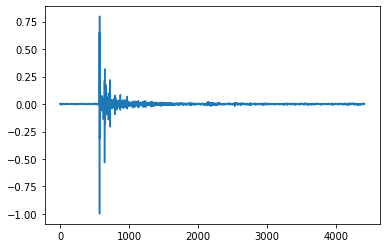

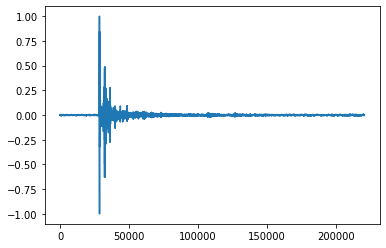

In [19]:
div = 50
signal_d_image_array = []
for i in range(0,2000):
    sig = (signal_d[i])[0::div] ## Take every 50th element
    signal_d_image_array.append(sig)
signal_d_image_array = np.array(signal_d_image_array)

plt.figure() ##Plot and compare to orginal just to see if the data doesn't keep its shape when plotted as an image
plt.plot(np.arange(signal_d_image_array[20].shape[0]),signal_d_image_array[20])
plt.figure()
plt.plot(np.arange(signal_d[20].shape[0]),signal_d[20])

signal_d_image_array_model = signal_d_image_array.reshape(2000,int(220500/div),1)### Reshape for traing model

The data retains it's shape

In [20]:
###Repeat tf.datasetcode repeated
dataset = tf.data.Dataset.from_tensor_slices((signal_d_image_array_model, labels))
dataset = dataset.shuffle(buffer_size = 100)
dataset = dataset.batch(32) 
train_dataset , validate_dataset , test_dataset = train_validate_test(dataset ,0.6 , 0.1 , 0.3)
train_dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)###improve perfomance of code timing 
validate_dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)### Prefetch process the next batch of data while training current data
test_dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)######cache prevents repeating tasks,autotune makes the amount data being prefetched be done automatically the amount can change each time
train_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))#### Convert to int8 as that stores the least amount data
validate_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))
test_dataset.map(lambda x, y: (x, tf.cast(y, tf.int8)))

<_MapDataset element_spec=(TensorSpec(shape=(None, 4410, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 50), dtype=tf.int8, name=None))>

In [21]:
input_model_shape = (4410,1)
model_2 = models.Sequential([

    
    layers.Conv1D(12 , 3, activation = 'relu', input_shape = input_model_shape,padding = 'same'),
    layers.Conv1D(3, 3 , activation = 'relu', input_shape = input_model_shape,padding='same'),
    layers.MaxPooling1D(pool_size = 1, strides =1 ,padding='same'),
    layers.BatchNormalization(),


    
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(120, activation = 'relu'),
    layers.Dropout(0.4),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(50, activation = 'softmax'),
])

In [22]:
Optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_2.compile(
    optimizer = Optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

estop = EarlyStopping (monitor = 'loss', min_delta = 0.000003, patience = 10, verbose = 1)####Made the stop condition impossible

In [23]:
history = model_2.fit(
    train_dataset,
    epochs = 30,
    batch_size = 32,
    verbose = 1,
    validation_data = validate_dataset,
    callbacks = [estop]
)

Epoch 1/30
37/37 [==============================] - 3s 60ms/step - loss: 4.0274 - accuracy: 0.0262 - val_loss: 3.9010 - val_accuracy: 0.0469
Epoch 2/30
37/37 [==============================] - 2s 54ms/step - loss: 3.4628 - accuracy: 0.1729 - val_loss: 3.8599 - val_accuracy: 0.0573
Epoch 3/30
37/37 [==============================] - 2s 58ms/step - loss: 2.9681 - accuracy: 0.2812 - val_loss: 3.8119 - val_accuracy: 0.1719
Epoch 4/30
37/37 [==============================] - 2s 54ms/step - loss: 2.4822 - accuracy: 0.3913 - val_loss: 3.7261 - val_accuracy: 0.2135
Epoch 5/30
37/37 [==============================] - 2s 58ms/step - loss: 1.9878 - accuracy: 0.5008 - val_loss: 3.6048 - val_accuracy: 0.2604
Epoch 6/30
37/37 [==============================] - 2s 54ms/step - loss: 1.6265 - accuracy: 0.6010 - val_loss: 3.3958 - val_accuracy: 0.4375
Epoch 7/30
37/37 [==============================] - 2s 57ms/step - loss: 1.4644 - accuracy: 0.6413 - val_loss: 3.1905 - val_accuracy: 0.4740
Epoch 8/30
37

In [24]:
model_2.evaluate(test_dataset)

20/20 [==============================] - 0s 10ms/step - loss: 0.0092 - accuracy: 1.0000


[0.009228418581187725, 1.0]

The high test accuracy could suggest there is some overfitting

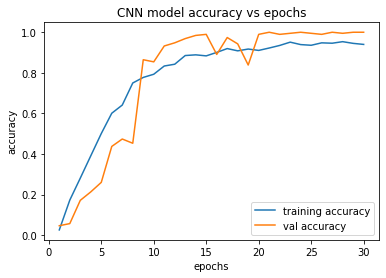

In [25]:
epochs = range(1,31) 
plt.plot(epochs, history.history['accuracy'], label = 'training accuracy')
plt.plot(epochs, history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('CNN model accuracy vs epochs')
plt.legend(loc = 'best')

## Warning
Same as the warning cell seen previous in the spectrogram case.

In [26]:
y_pred_array = np.array([])
y_true_array = np.array([])
for i in range(0,100): ### Do multiple times due the model and dataset changing each time
    y_pred = np.array([])  
    y_true = np.array([])  
    for image_batch, label_batch in test_dataset: 
        y_true = np.append(y_true,(np.argmax(label_batch,axis = -1).flatten())) ### Label
        preds = model_2.predict(image_batch) ### Prediction
        y_pred = np.append(y_pred,(np.argmax(preds, axis = - 1).flatten()))
    y_pred_array = np.append(y_pred_array,y_pred)
    y_true_array = np.append(y_true_array,y_true)
## Flatten due the predictions being in batches and having looped multiple times
y_pred_array = y_pred_array.tolist()
y_true_array = y_true_array.tolist()

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


Text(339.0, 0.5, 'Actual value')

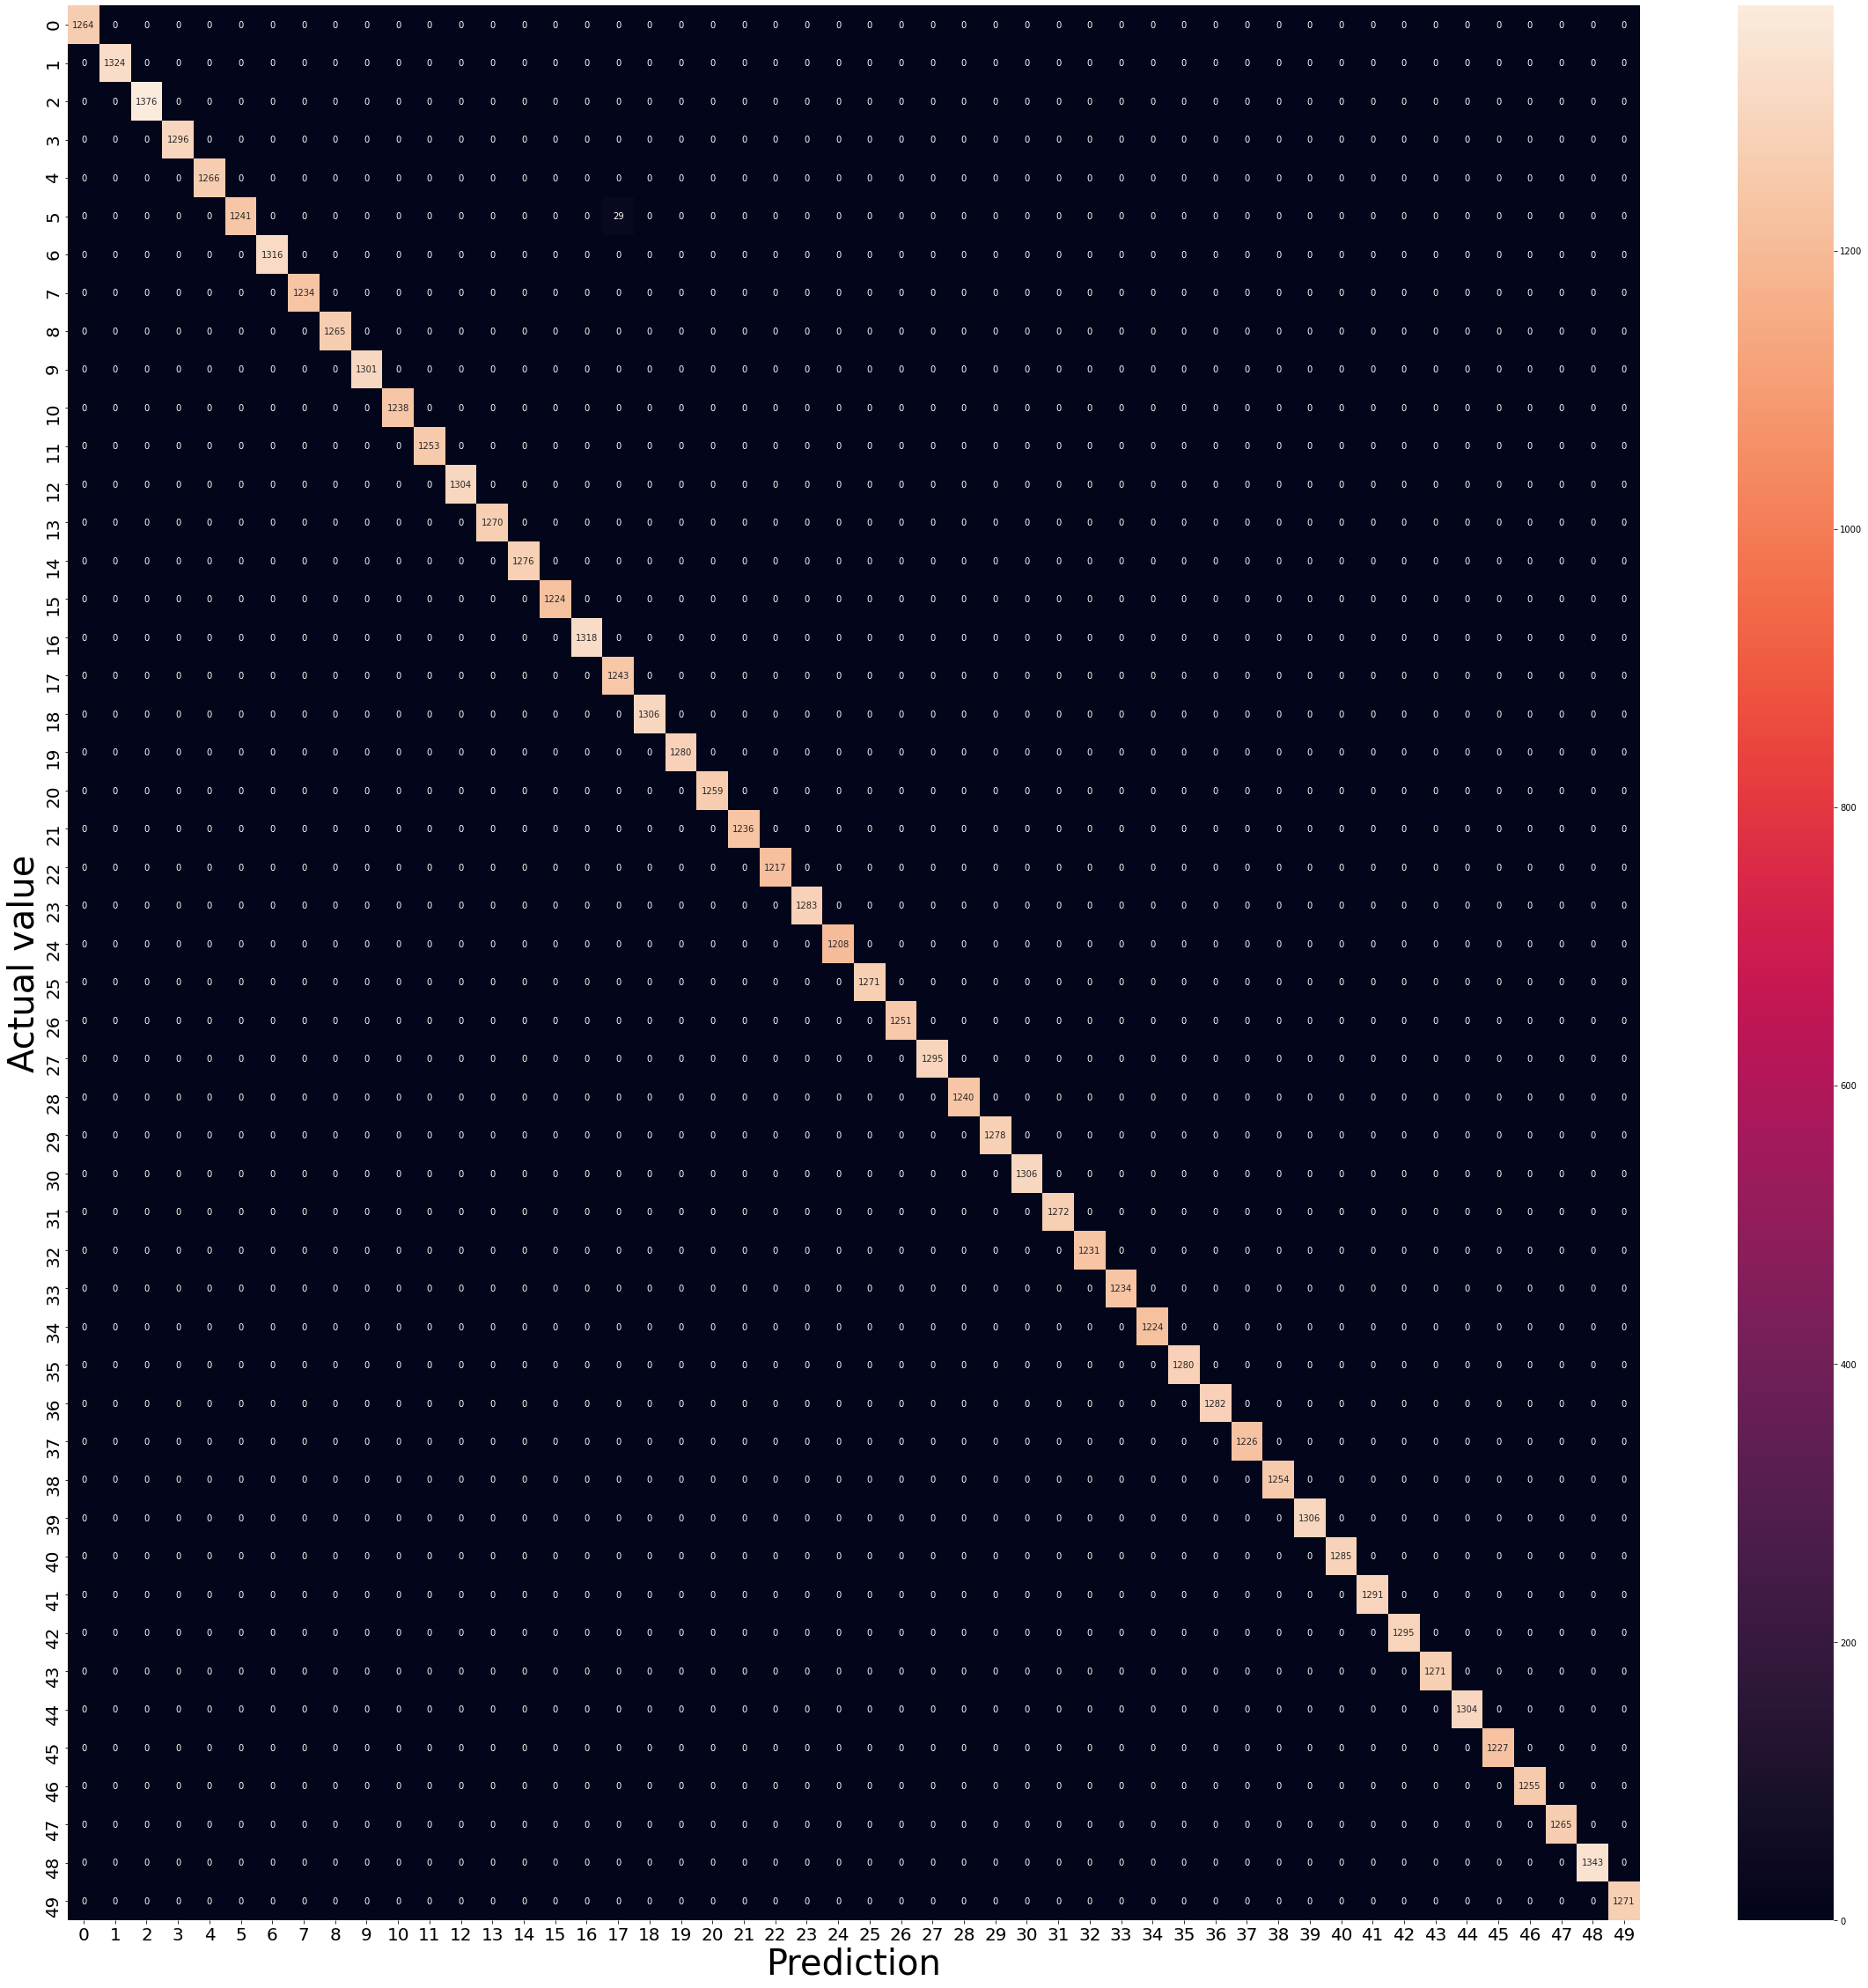

In [27]:
from sklearn.metrics import classification_report

cm = tf.math.confusion_matrix(labels = y_true_array, predictions = y_pred_array)
import seaborn as sn
plt.figure(figsize = (40,40))
sn.heatmap(cm, annot = True, fmt ='d')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Prediction',fontsize =40)
plt.ylabel('Actual value',fontsize = 40)

In [28]:
print("Classifiction Report \n" , classification_report(y_true_array , y_pred_array))

Classifiction Report 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1264
         1.0       1.00      1.00      1.00      1324
         2.0       1.00      1.00      1.00      1376
         3.0       1.00      1.00      1.00      1296
         4.0       1.00      1.00      1.00      1266
         5.0       1.00      0.98      0.99      1270
         6.0       1.00      1.00      1.00      1316
         7.0       1.00      1.00      1.00      1234
         8.0       1.00      1.00      1.00      1265
         9.0       1.00      1.00      1.00      1301
        10.0       1.00      1.00      1.00      1238
        11.0       1.00      1.00      1.00      1253
        12.0       1.00      1.00      1.00      1304
        13.0       1.00      1.00      1.00      1270
        14.0       1.00      1.00      1.00      1276
        15.0       1.00      1.00      1.00      1224
        16.0       1.00      1.00      1.00      1318
    

Need to analyse sea waves again

In [29]:
cracking_fire_df = meta.loc[meta['category'] == 'crackling_fire']
keyboard_df = meta.loc[meta['category'] == 'keyboard_typing']
laugh_df = meta.loc[meta['category'] == 'laughing']
print(cracking_fire_df.head())
print(keyboard_df.head())
print(laugh_df.head())

            filename  fold  target        category  esc10  src_file take
54  1-17150-A-12.wav     1      12  crackling_fire   True     17150    A
63  1-17565-A-12.wav     1      12  crackling_fire   True     17565    A
65  1-17742-A-12.wav     1      12  crackling_fire   True     17742    A
66  1-17808-A-12.wav     1      12  crackling_fire   True     17808    A
67  1-17808-B-12.wav     1      12  crackling_fire   True     17808    B
             filename  fold  target         category  esc10  src_file take
36     1-137-A-32.wav     1      32  keyboard_typing  False       137    A
265  1-53501-A-32.wav     1      32  keyboard_typing  False     53501    A
302  1-61212-A-32.wav     1      32  keyboard_typing  False     61212    A
309  1-62594-A-32.wav     1      32  keyboard_typing  False     62594    A
355  1-79711-A-32.wav     1      32  keyboard_typing  False     79711    A
             filename  fold  target  category  esc10  src_file take
68    1-1791-A-26.wav     1      26  laughin

## Plot the waveforms
First the normal waveforms will be plotted and then the transformed.

Text(0.5, 1.0, 'Laugh Waveform')

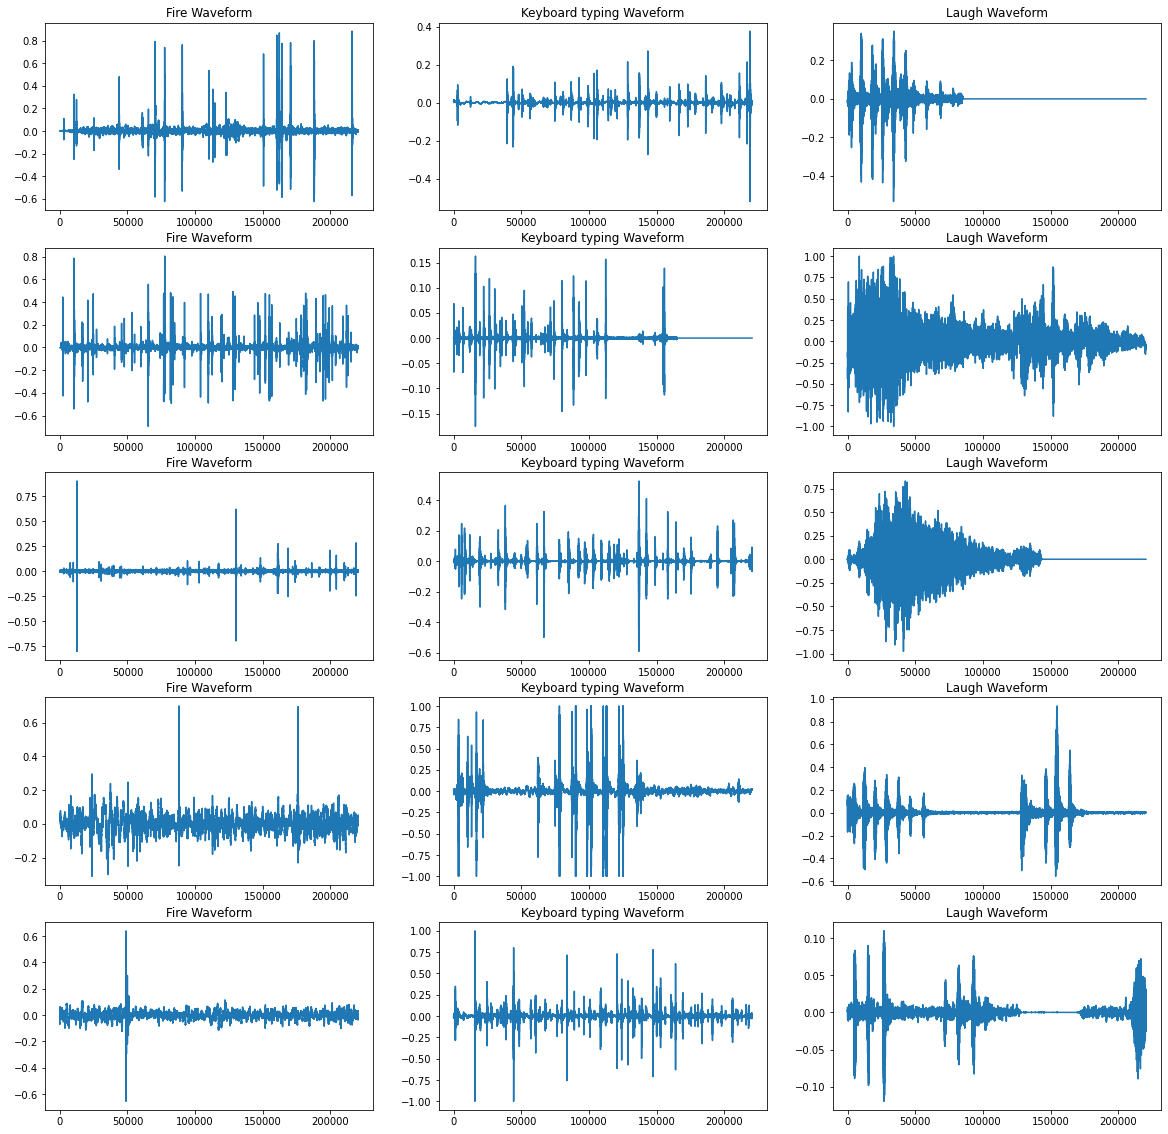

In [30]:
fig = plt.figure(figsize=(20,20))
rows = 5
columns = 3
x_axis = np.arange(len(signal_d[0]))

fig.add_subplot(rows, columns, 1)   
plt.plot(x_axis,signal_d[54])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 2) 
plt.plot(x_axis,signal_d[36])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 3)   
plt.plot(x_axis,signal_d[68])  
plt.title("Laugh Waveform")
fig.add_subplot(rows, columns, 4)   
plt.plot(x_axis,signal_d[63])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 5) 
plt.plot(x_axis,signal_d[265])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 6)   
plt.plot(x_axis,signal_d[154])  
plt.title("Laugh Waveform")
fig.add_subplot(rows, columns, 7)   
plt.plot(x_axis,signal_d[65])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 8) 
plt.plot(x_axis,signal_d[302])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 9)   
plt.plot(x_axis,signal_d[155])  
plt.title("Laugh Waveform")
fig.add_subplot(rows, columns, 10)   
plt.plot(x_axis,signal_d[66])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 11) 
plt.plot(x_axis,signal_d[309])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 12)   
plt.plot(x_axis,signal_d[174])  
plt.title("Laugh Waveform")
fig.add_subplot(rows, columns, 13)   
plt.plot(x_axis,signal_d[67])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 14) 
plt.plot(x_axis,signal_d[355])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 15)   
plt.plot(x_axis,signal_d[183])  
plt.title("Laugh Waveform")

## Transformed Waveforms

Text(0.5, 1.0, 'Laugh Waveform')

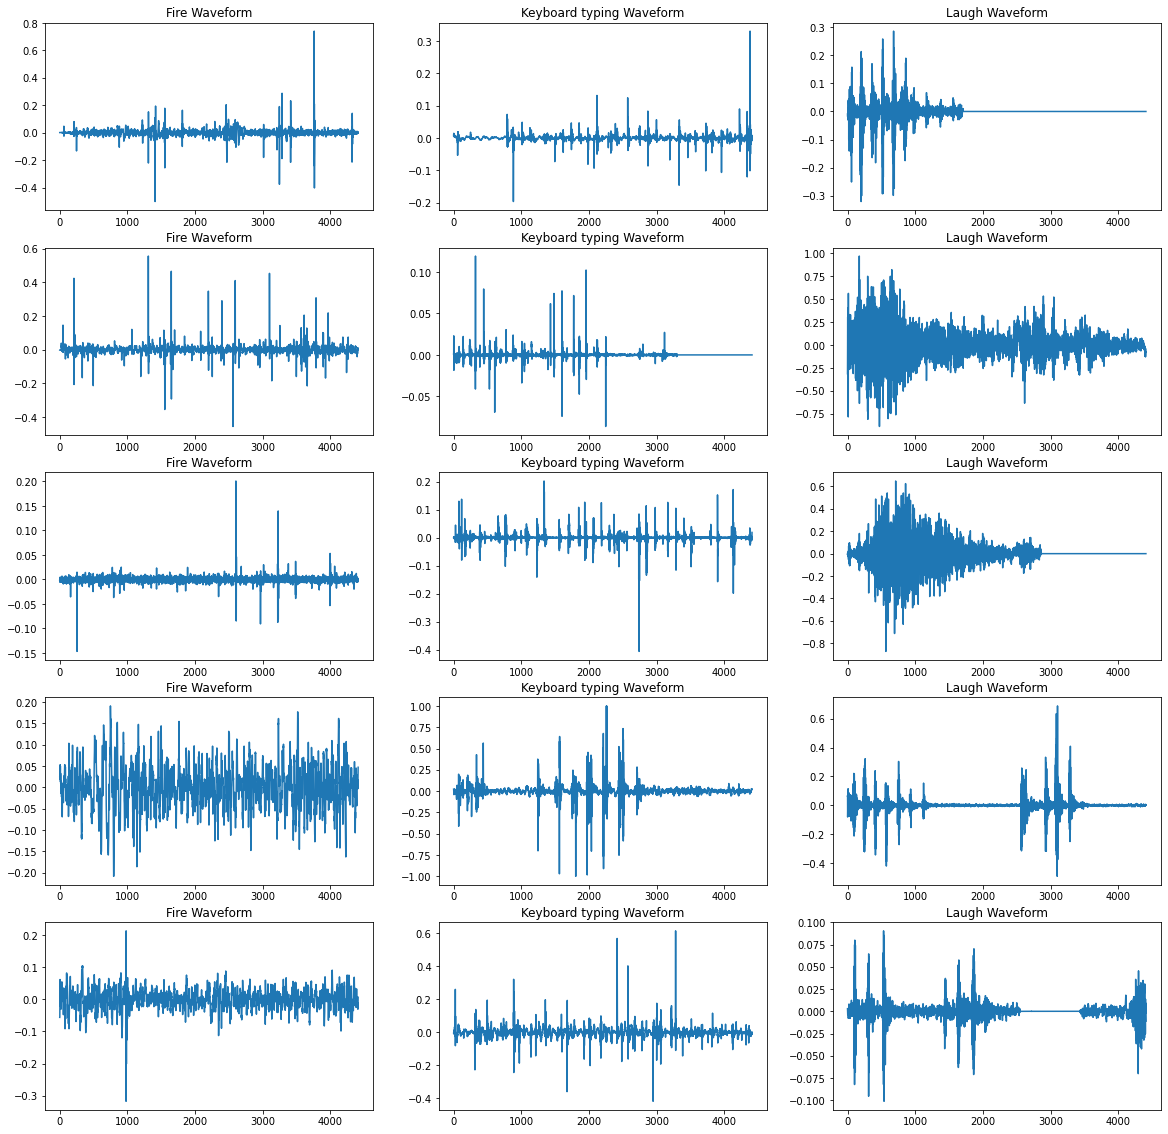

In [31]:
fig = plt.figure(figsize=(20,20))
rows = 5
columns = 3
x_axis = np.arange(len(signal_d_image_array[0]))

fig.add_subplot(rows, columns, 1)   
plt.plot(x_axis,signal_d_image_array[54])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 2) 
plt.plot(x_axis,signal_d_image_array[36])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 3)   
plt.plot(x_axis,signal_d_image_array[68])  
plt.title("Laugh Waveform")
fig.add_subplot(rows, columns, 4)   
plt.plot(x_axis,signal_d_image_array[63])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 5) 
plt.plot(x_axis,signal_d_image_array[265])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 6)   
plt.plot(x_axis,signal_d_image_array[154])  
plt.title("Laugh Waveform")
fig.add_subplot(rows, columns, 7)   
plt.plot(x_axis,signal_d_image_array[65])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 8) 
plt.plot(x_axis,signal_d_image_array[302])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 9)   
plt.plot(x_axis,signal_d_image_array[155])  
plt.title("Laugh Waveform")
fig.add_subplot(rows, columns, 10)   
plt.plot(x_axis,signal_d_image_array[66])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 11) 
plt.plot(x_axis,signal_d_image_array[309])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 12)   
plt.plot(x_axis,signal_d_image_array[174])  
plt.title("Laugh Waveform")
fig.add_subplot(rows, columns, 13)   
plt.plot(x_axis,signal_d_image_array[67])  
plt.title("Fire Waveform")
fig.add_subplot(rows, columns, 14) 
plt.plot(x_axis,signal_d_image_array[355])  
plt.title("Keyboard typing Waveform")
fig.add_subplot(rows, columns, 15)   
plt.plot(x_axis,signal_d_image_array[183])  
plt.title("Laugh Waveform")

## Analysis
The model has a very high test accuracy even when the test accuracy is 30% of the dataset.Usually 98%+ accuracy would suggest overfitting however, in this scenario this could be normal and not overfitting due to the size of the dataset being a bit small.This model ocassionally struggles to tell apart waveformsn from laughing,fire and keyboard typing as shown in the confusion matrix and recall scores. From the waveforms plots I would suggest that perhaps this occurs due to the waveformsn having similar amplitude peaks pattern. If the model places a huge emphasis on the pattern of the peaks then this issue would make sense.

# Conclusion
Both models share the same issue with struggling to categorise keyboard sounds. Spectrograms struggle due the colour gradient pattern being similar to the crickets and sea waves. Waveforms struggle possibly due the peaks in amplitude having a similar pattern with other sounds